STAT 453: Deep Learning (Spring 2021)  
Instructor: Sebastian Raschka (sraschka@wisc.edu)  

Course website: http://pages.stat.wisc.edu/~sraschka/teaching/stat453-ss2021/  
GitHub repository: https://github.com/rasbt/stat453-deep-learning-ss21

---

# VAE Latent Space Arithmetic

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch

Author: Sebastian Raschka

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 7.21.0

torch: 1.8.1+cu111



## Imports

In [2]:
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

#### Import utility functions

In [3]:
from helper_data import get_dataloaders_celeba
from helper_data import compute_average_faces
from helper_plotting import plot_modified_faces

In [4]:
##########################
### SETTINGS
##########################

# Device
CUDA_DEVICE_NUM = 3
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

# Hyperparameters
RANDOM_SEED = 123
BATCH_SIZE = 5000

Device: cuda:3


## Dataset

In [5]:
##########################
### Dataset
##########################


custom_transforms = torchvision.transforms.Compose([
    torchvision.transforms.CenterCrop((128, 128)),
    torchvision.transforms.ToTensor(),
    #torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


train_loader, valid_loader, test_loader = get_dataloaders_celeba(
    batch_size=BATCH_SIZE,
    train_transforms=custom_transforms,
    test_transforms=custom_transforms,
    num_workers=2)

Files already downloaded and verified


In [6]:
torch.manual_seed(RANDOM_SEED)
for images, labels in train_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    #print(labels[:10])
    break
    
EXAMPLE_IMAGE = images[1]

Image batch dimensions: torch.Size([5000, 3, 128, 128])
Image label dimensions: torch.Size([5000, 40])


<br>
<br>
<br>

## 1) Image Manipulation in Original Space

### Compute Average Faces

In [7]:
avg_img_with_feat, avg_img_without_feat = compute_average_faces(
    feature_idx=31, # smiling
    image_dim=(3, 128, 128),
    data_loader=train_loader,
    device=None,
    encoding_fn=None)

#### Average Smiling Face

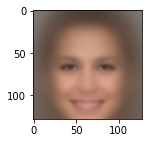

In [8]:
fig, ax = plt.subplots(figsize=(2, 2))
ax.imshow((avg_img_with_feat).permute(1, 2, 0))
plt.show()

#### Average Non-Smiling Face

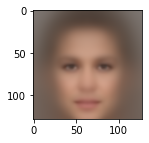

In [9]:
fig, ax = plt.subplots(figsize=(2, 2))
ax.imshow((avg_img_without_feat).permute(1, 2, 0))
plt.show()

### Manipulate Example Face Image

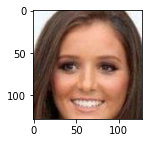

In [10]:
fig, ax = plt.subplots(figsize=(2, 2))

ax.imshow(EXAMPLE_IMAGE.permute(1, 2, 0))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

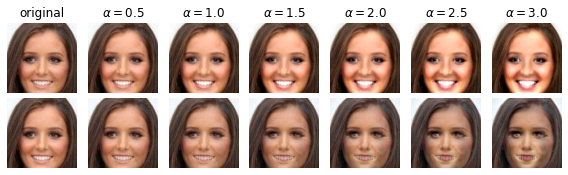

In [11]:
diff = (avg_img_with_feat - avg_img_without_feat)
plot_modified_faces(original=images[1],
                    diff=diff)

plt.tight_layout()
plt.show()

<br>
<br>
<br>
<br>
<br>
<br>

## 2) Image Manipulation in Latent Space

In [12]:
##########################
### MODEL
##########################


class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :128, :128]


class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
                nn.Conv2d(3, 32, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(32),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.Conv2d(32, 64, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.Conv2d(64, 64, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.Conv2d(64, 64, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.Flatten(),
        )    
        
        self.z_mean = torch.nn.Linear(4096, 200)
        self.z_log_var = torch.nn.Linear(4096, 200)
        
        self.decoder = nn.Sequential(
                torch.nn.Linear(200, 4096),
                Reshape(-1, 64, 8, 8),
                #
                nn.ConvTranspose2d(64, 64, stride=2, kernel_size=3),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.ConvTranspose2d(64, 64, stride=2, kernel_size=3, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.ConvTranspose2d(64, 32, stride=2, kernel_size=3, padding=1),
                nn.BatchNorm2d(32),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.ConvTranspose2d(32, 3, stride=2, kernel_size=3, padding=1),
                #
                Trim(),  # 3x129x129 -> 3x128x128
                nn.Sigmoid()
                )

    def reparameterize(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(z_mu.get_device())
        z = z_mu + eps * torch.exp(z_log_var/2.) 
        return z
    

    def encoding_fn(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        return encoded
    
        
    def forward(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        decoded = self.decoder(encoded)
        return encoded, z_mean, z_log_var, decoded

Load model:

In [13]:
model = VAE()
model.load_state_dict(torch.load('vae_celeba_02.pt', map_location=torch.device('cpu')))
model.to(DEVICE);

### Compute Average Faces in Latent Space -- More or Less Smiling

In [14]:
avg_img_with_feat, avg_img_without_feat = compute_average_faces(
    feature_idx=31, # smiling
    image_dim=200,
    data_loader=train_loader,
    device=DEVICE,
    encoding_fn=model.encoding_fn)

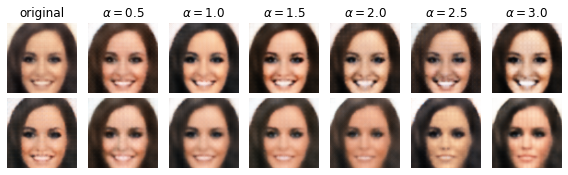

In [15]:
diff = (avg_img_with_feat - avg_img_without_feat)

example_img = EXAMPLE_IMAGE.unsqueeze(0).to(DEVICE)
with torch.no_grad():
    encoded = model.encoding_fn(example_img).squeeze(0).to('cpu')

plot_modified_faces(original=encoded,
                    decoding_fn=model.decoder,
                    device=DEVICE,
                    diff=diff)

plt.tight_layout()
plt.show()

### Compute Average Faces in Latent Space -- With or Without Glasses

In [16]:
avg_img_with_feat, avg_img_without_feat = compute_average_faces(
    feature_idx=15, # eyeglasses
    image_dim=200,
    data_loader=train_loader,
    device=DEVICE,
    encoding_fn=model.encoding_fn)

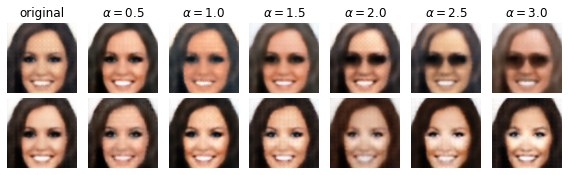

In [17]:
diff = (avg_img_with_feat - avg_img_without_feat)

example_img = EXAMPLE_IMAGE.unsqueeze(0).to(DEVICE)
with torch.no_grad():
    encoded = model.encoding_fn(example_img).squeeze(0).to('cpu')

plot_modified_faces(original=encoded,
                    decoding_fn=model.decoder,
                    device=DEVICE,
                    diff=diff)

plt.tight_layout()
plt.show()